In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder

D:\Anaconda\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
gift_df = pd.read_csv("amazon_reviews_us_Gift_Card_v1_00.tsv", sep="\t", on_bad_lines="skip")

In [4]:
empathetic_df = pd.read_csv("emotion-emotion_69k.csv")

In [5]:
gift_df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,24371595,R27ZP1F1CD0C3Y,B004LLIL5A,346014806,Amazon eGift Card - Celebrate,Gift Card,5,0,0,N,Y,Five Stars,Great birthday gift for a young adult.,2015-08-31
1,US,42489718,RJ7RSBCHUDNNE,B004LLIKVU,473048287,Amazon.com eGift Cards,Gift Card,5,0,0,N,Y,Gift card for the greatest selection of items ...,It's an Amazon gift card and with over 9823983...,2015-08-31
2,US,861463,R1HVYBSKLQJI5S,B00IX1I3G6,926539283,Amazon.com Gift Card Balance Reload,Gift Card,5,0,0,N,Y,Five Stars,Good,2015-08-31
3,US,25283295,R2HAXF0IIYQBIR,B00IX1I3G6,926539283,Amazon.com Gift Card Balance Reload,Gift Card,1,0,0,N,Y,One Star,Fair,2015-08-31
4,US,397970,RNYLPX611NB7Q,B005ESMGV4,379368939,"Amazon.com Gift Cards, Pack of 3 (Various Desi...",Gift Card,5,0,0,N,Y,Five Stars,I can't believe how quickly Amazon can get the...,2015-08-31


In [6]:
empathetic_df.head()

,Unnamed: 0,Situation,emotion,empathetic_dialogues,labels,Unnamed: 5,Unnamed: 6
0,0,I remember going to the fireworks with my best...,sentimental,Customer :I remember going to see the firework...,"Was this a friend you were in love with, or ju...",NaN,NaN
1,1,I remember going to the fireworks with my best...,sentimental,Customer :This was a best friend. I miss her.\...,Where has she gone?,NaN,NaN
2,2,I remember going to the fireworks with my best...,sentimental,Customer :We no longer talk.\nAgent :,Oh was this something that happened because of...,NaN,NaN
3,3,I remember going to the fireworks with my best...,sentimental,Customer :Was this a friend you were in love w...,This was a best friend. I miss her.,NaN,NaN
4,4,I remember going to the fireworks with my best...,sentimental,Customer :Where has she gone?\nAgent :,We no longer talk.,NaN,NaN


In [7]:
# Clean the empathic data under the current structure
empathetic_df = empathetic_df[['Situation', 'emotion', 'empathetic_dialogues', 'labels']].copy()

In [8]:
# Rename the fields to unify the format
empathetic_df.rename(columns={
    'Situation': 'situation',
    'emotion': 'emotion',
    'empathetic_dialogues': 'text',
    'labels': 'target'
}, inplace=True)

In [9]:
# Clean the text content (remove special characters and standardize the format)
def clean_text(text):
    text = re.sub(r"<.*?>", "", str(text))
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text.lower().strip()

empathetic_df['text'] = empathetic_df['text'].apply(clean_text)
empathetic_df['situation'] = empathetic_df['situation'].apply(clean_text)
empathetic_df['target'] = empathetic_df['target'].apply(clean_text)

In [10]:
empathetic_df.head()

,situation,emotion,text,target
0,i remember going to the fireworks with my best...,sentimental,customer i remember going to see the fireworks...,was this a friend you were in love with or jus...
1,i remember going to the fireworks with my best...,sentimental,customer this was a best friend i miss her\nagent,where has she gone
2,i remember going to the fireworks with my best...,sentimental,customer we no longer talk\nagent,oh was this something that happened because of...
3,i remember going to the fireworks with my best...,sentimental,customer was this a friend you were in love wi...,this was a best friend i miss her
4,i remember going to the fireworks with my best...,sentimental,customer where has she gone\nagent,we no longer talk


In [11]:
print(empathetic_df.columns)

Index(['situation', 'emotion', 'text', 'target'], dtype='object')


In [12]:
print("Unique emotion categories:")
print(empathetic_df['emotion'].unique())

Unique emotion categories:
['sentimental' 'afraid' 'proud' 'faithful' 'terrified' 'joyful' 'angry'
 'sad' 'jealous' 'grateful' 'prepared' 'embarrassed' 'excited' 'annoyed'
 'lonely' 'ashamed' 'guilty' 'surprised' 'nostalgic' 'confident' 'furious'
 'disappointed' 'caring' 'trusting' 'disgusted' 'anticipating' 'anxious'
 'hopeful' 'content' 'impressed' 'apprehensive' 'devastated'
 ' I really killed it!' ' we were in a different country'
 't even like scary things'
 't believe I like the show Power so much. I was never really into shows like that'
 nan ' time to jump on the motorcycle and go cruising!'
 " a boy.  I hear all these different labor stories that aren't exactly reassuring!  "
 't believe my daughter taught herself how to play the ukelele. I was amazed'
 't think I wold like super heroes'
 "m so mad with my brother. He stole from me and didn't think I would notice. "
 " but what I didn't know was that he was working in the next room with the door open.  He approached and asked 

In [13]:
# Only keep valid emotion values
valid_emotions = {
    'sentimental', 'afraid', 'proud', 'faithful', 'terrified', 'joyful', 'angry',
    'sad', 'jealous', 'grateful', 'prepared', 'embarrassed', 'excited', 'annoyed',
    'lonely', 'ashamed', 'guilty', 'surprised', 'nostalgic', 'confident', 'furious',
    'disappointed', 'caring', 'trusting', 'disgusted', 'anticipating', 'anxious',
    'hopeful', 'content', 'impressed', 'apprehensive', 'devastated'
}

empathetic_df = empathetic_df[empathetic_df['emotion'].isin(valid_emotions)].copy()

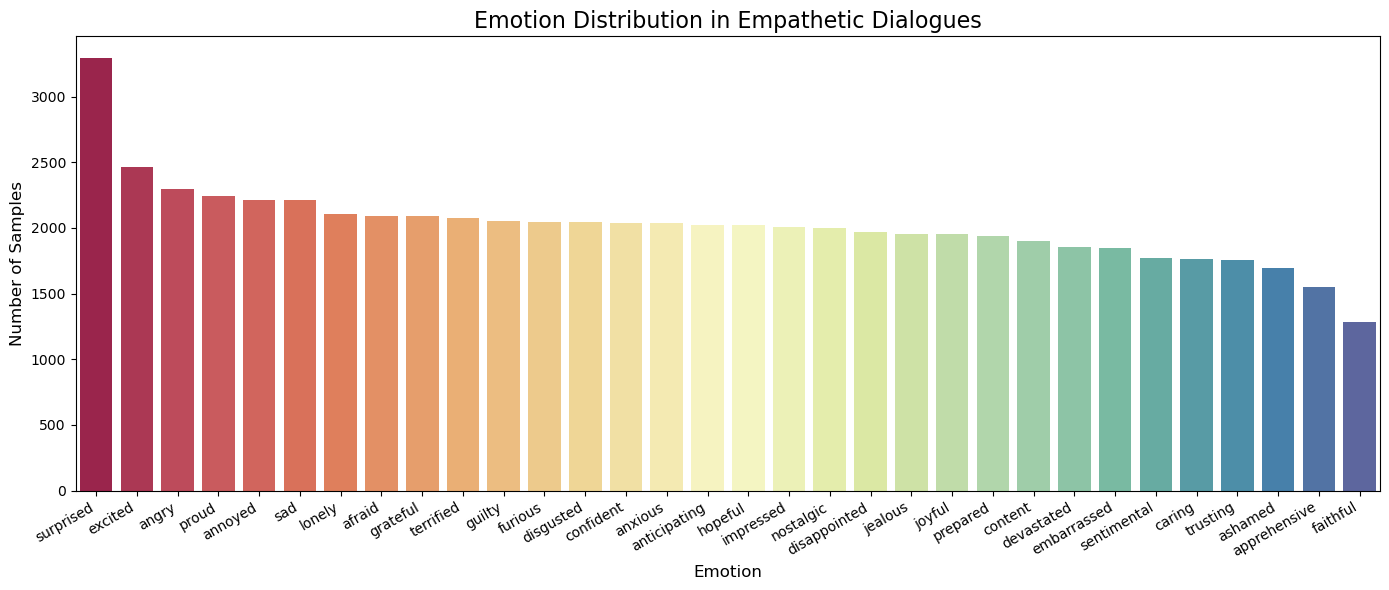

In [14]:
plt.figure(figsize=(14, 6))  
order = empathetic_df['emotion'].value_counts().index 

sns.countplot(data=empathetic_df, x='emotion', order=order, palette="Spectral")

plt.title("Emotion Distribution in Empathetic Dialogues", fontsize=16)
plt.xlabel("Emotion", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)

plt.xticks(rotation=30, ha='right', fontsize=10) 
plt.tight_layout()
plt.show()

In [15]:
# Merge fine-grained emotions into 8 emotion groups
emotion_map = {
    'joyful': 'positive', 'grateful': 'positive', 'excited': 'positive', 'hopeful': 'positive', 'proud': 'positive', 'content': 'positive', 'confident': 'positive', 'impressed': 'positive',

    'sad': 'negative', 'ashamed': 'negative', 'embarrassed': 'negative', 'disappointed': 'negative', 'annoyed': 'negative', 'jealous': 'negative', 'furious': 'negative', 'devastated': 'negative',

    'afraid': 'fear', 'terrified': 'fear', 'apprehensive': 'fear', 'anxious': 'fear',

    'caring': 'love', 'faithful': 'love', 'trusting': 'love',

    'surprised': 'surprise', 'nostalgic': 'surprise',

    'guilty': 'guilt',

    'lonely': 'lonely',

    'sentimental': 'sentimental', 'prepared': 'sentimental', 'anticipating': 'sentimental', 'disgusted': 'sentimental'
}

empathetic_df['emotion_group'] = empathetic_df['emotion'].map(emotion_map)

In [16]:
empathetic_df = empathetic_df[empathetic_df['emotion_group'].notnull()].copy()

In [17]:
# Check for missing values
print("Missing values:")
print(empathetic_df.isnull().sum())

Missing values:
situation        0
emotion          0
text             0
target           0
emotion_group    0
dtype: int64


In [18]:
# Summarize the distribution of emotion categories
emotion_counts = empathetic_df['emotion'].value_counts()
print("Emotion distribution in empathetic_df:")
print(emotion_counts)
print("\nImbalance ratio (max/min):", emotion_counts.max() / emotion_counts.min())

Emotion distribution in empathetic_df:
emotion
surprised       3295
excited         2465
proud           2247
annoyed         2213
sad             2213
lonely          2106
afraid          2094
grateful        2091
terrified       2074
guilty          2053
furious         2045
disgusted       2044
confident       2037
anxious         2037
anticipating    2026
hopeful         2019
impressed       2004
nostalgic       1996
disappointed    1969
jealous         1955
joyful          1953
prepared        1937
content         1903
devastated      1856
embarrassed     1844
sentimental     1773
caring          1765
trusting        1755
ashamed         1694
apprehensive    1549
faithful        1283
Name: count, dtype: int64

Imbalance ratio (max/min): 2.568199532346064


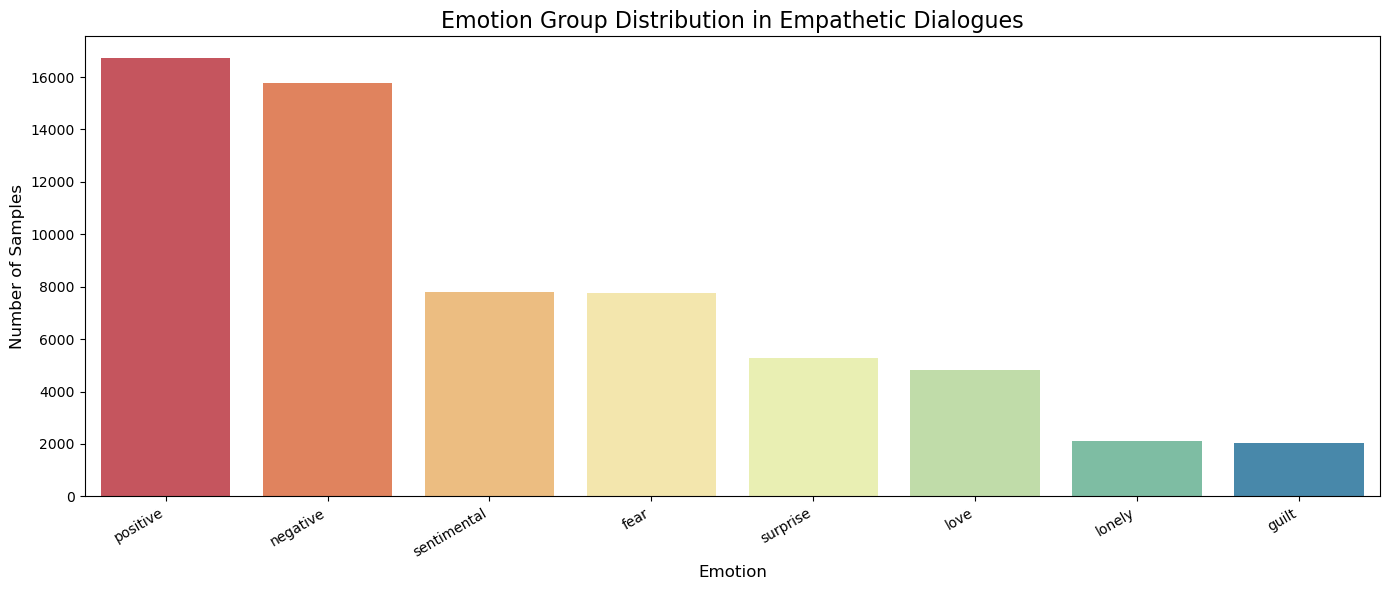

In [19]:
plt.figure(figsize=(14, 6))  
order = empathetic_df['emotion_group'].value_counts().index 

sns.countplot(data=empathetic_df, x='emotion_group', order=order, palette="Spectral")

plt.title("Emotion Group Distribution in Empathetic Dialogues", fontsize=16)
plt.xlabel("Emotion", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)

plt.xticks(rotation=30, ha='right', fontsize=10) 
plt.tight_layout()
plt.show()

In [20]:
# Keep only the necessary fields and remove the null values
gift_df = gift_df[['review_body', 'star_rating']].dropna()
gift_df['review_body'] = gift_df['review_body'].astype(str)

In [21]:
# Text Cleaning Function
def clean_text(text):
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text.lower().strip()

gift_df['text'] = gift_df['review_body'].apply(clean_text)

In [22]:
# Handling Missing Values and Invalid Text
gift_df['text'] = gift_df['text'].fillna('').astype(str)
gift_df = gift_df[gift_df['text'].str.strip() != '']    

In [23]:
print("Missing Value:")
print(gift_df.isnull().sum())

Missing Value:
review_body    0
star_rating    0
text           0
dtype: int64


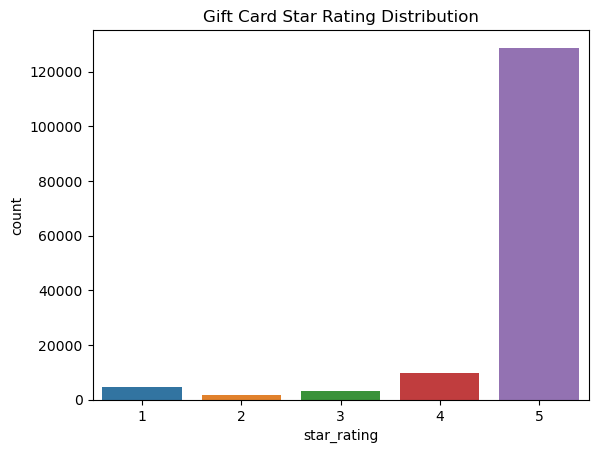

In [24]:
sns.countplot(data=gift_df, x="star_rating")
plt.title("Gift Card Star Rating Distribution")
plt.show()

In [25]:
# Three types of emotions: 0 = Negative (1, 2 stars), 1 = Neutral (3 stars), 2 = Positive (4, 5 stars)
gift_df['sentiment'] = gift_df['star_rating'].replace({
    1: 0, 2: 0, 3: 1, 4: 1, 5: 2
})

In [26]:
sentiment_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
gift_df['sentiment_label'] = gift_df['sentiment'].map(sentiment_map)

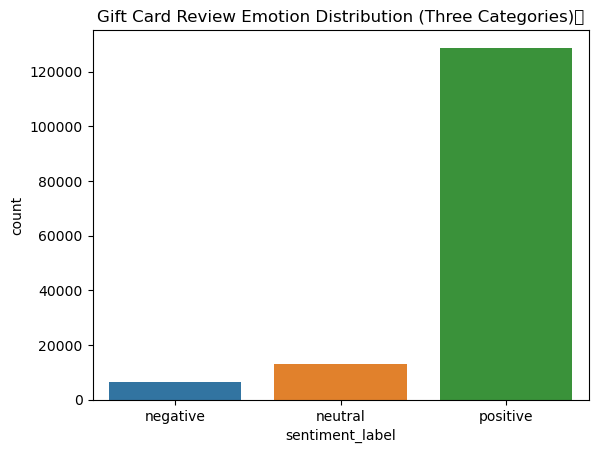

In [27]:
sns.countplot(data=gift_df, x="sentiment_label", order=["negative", "neutral", "positive"])
plt.title("Gift Card Review Emotion Distribution (Three Categories)）")
plt.show()

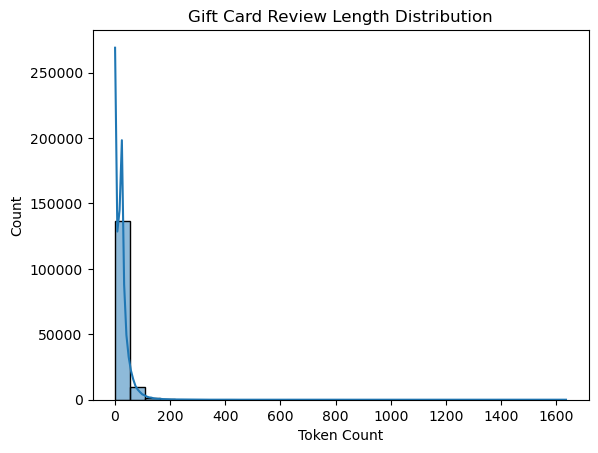

In [28]:
# Comment Length Distribution
gift_df['text_length'] = gift_df['text'].apply(lambda x: len(x.split()))
sns.histplot(gift_df['text_length'], bins=30, kde=True)
plt.title("Gift Card Review Length Distribution")
plt.xlabel("Token Count")
plt.show()

In [29]:
empathetic_df['text_len'] = empathetic_df['text'].apply(lambda x: len(x.split()))

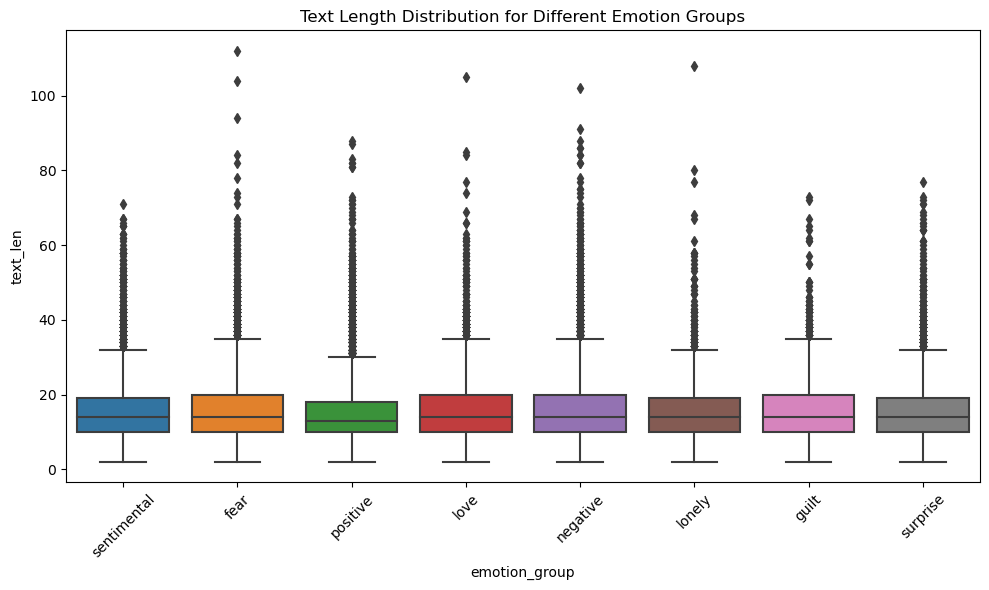

In [30]:
# Visualization of Emotion Group vs Text Length Distribution
plt.figure(figsize=(10, 6))
sns.boxplot(data=empathetic_df, x='emotion_group', y='text_len')
plt.title("Text Length Distribution for Different Emotion Groups")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

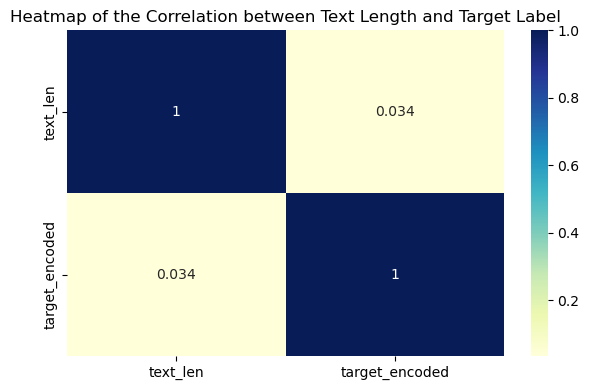

In [31]:
# Text Length vs Target Label
empathetic_df['target_encoded'] = LabelEncoder().fit_transform(empathetic_df['target'].astype(str))

corr_df = empathetic_df[['text_len', 'target_encoded']].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr_df, annot=True, cmap="YlGnBu")
plt.title("Heatmap of the Correlation between Text Length and Target Label")
plt.tight_layout()
plt.show()

In [32]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\NIO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NIO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
# Text Tokenization and Stop Word Removal
def tokenize(text):
    tokens = word_tokenize(text)
    return [w for w in tokens if w.isalpha() and w not in stop_words]

In [34]:
gift_df["tokens"] = gift_df["text"].apply(tokenize)
empathetic_df["tokens"] = empathetic_df["text"].apply(tokenize)

In [44]:
# High-Frequency Word Analysis (Remove customer and agent / Len >2)
def generate_top_words_by_group(df, group_label, column='text', top_n=30):
    tokens = df[df['emotion_group'] == group_label][column].apply(word_tokenize).explode()
    tokens = tokens.str.lower()
    tokens = tokens[tokens.str.isalpha()]
    tokens = tokens[~tokens.isin(stop_words)]
    tokens = tokens[~tokens.isin(['customer', 'agent'])]
    tokens = tokens[tokens.str.len() > 2] 
    return Counter(tokens)

In [45]:
def plot_group_wordcloud(counter, group_label):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(counter)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud - Emotion Group: {group_label}", fontsize=16)
    plt.show()

In [46]:
unique_groups = empathetic_df['emotion_group'].dropna().unique()

Top words for emotion group: sentimental
really: 499
like: 473
get: 473
going: 472
thats: 428
time: 397
good: 388
ready: 354
think: 306
cant: 298
--------------------------------------------------


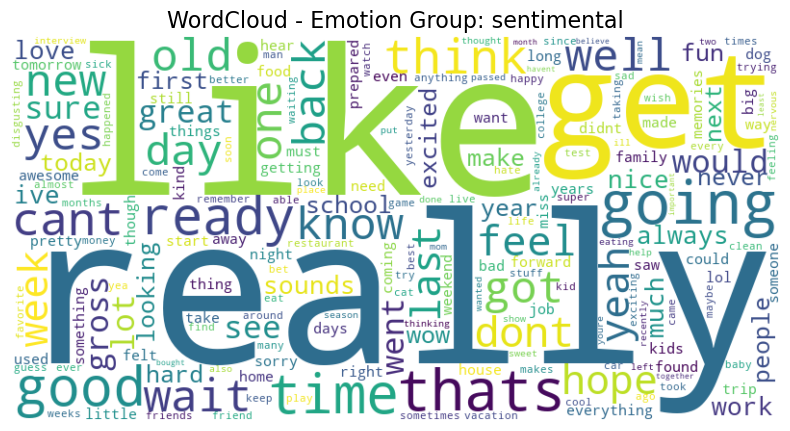

Top words for emotion group: fear
scared: 530
really: 516
get: 475
dont: 472
going: 447
like: 445
know: 422
nervous: 386
time: 362
think: 357
--------------------------------------------------


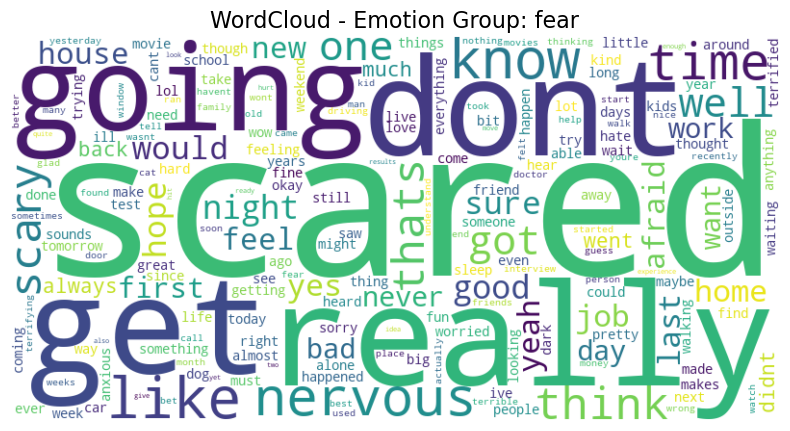

Top words for emotion group: positive
good: 1430
thats: 1326
really: 1273
great: 1055
get: 995
going: 986
like: 941
happy: 923
got: 872
time: 767
--------------------------------------------------


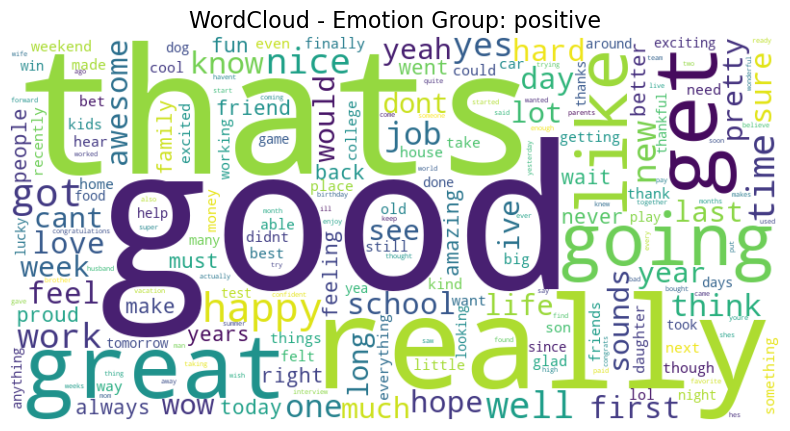

Top words for emotion group: love
good: 428
thats: 382
like: 327
really: 306
friend: 258
get: 223
time: 212
nice: 211
know: 208
care: 206
--------------------------------------------------


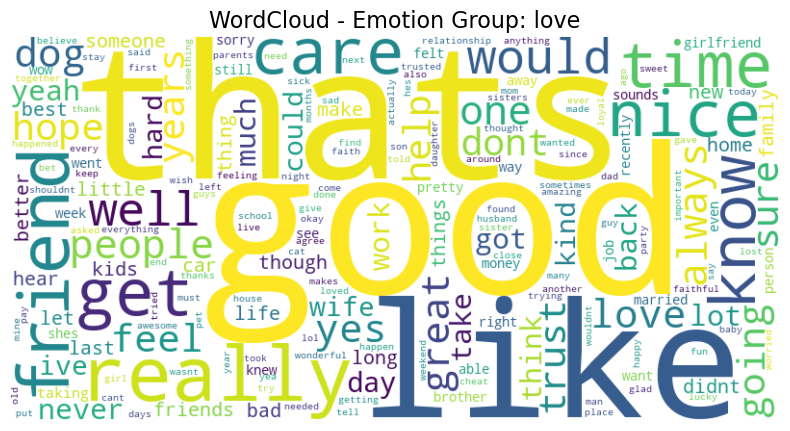

Top words for emotion group: negative
get: 1139
really: 1024
like: 839
got: 831
thats: 821
sorry: 752
time: 746
work: 727
know: 708
dont: 705
--------------------------------------------------


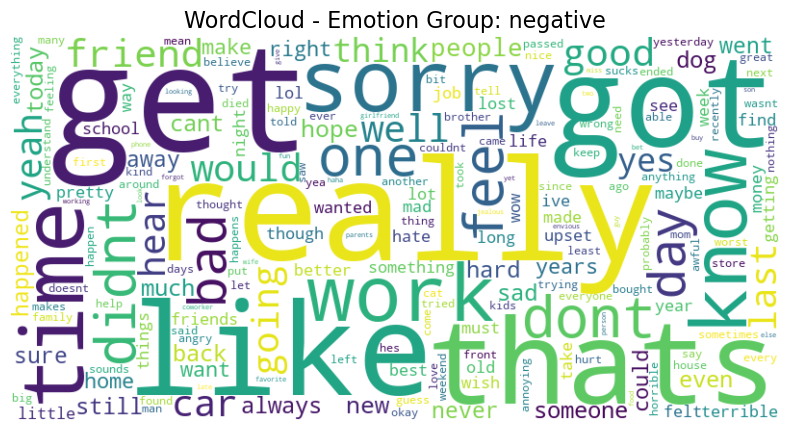

Top words for emotion group: lonely
alone: 250
friends: 214
time: 167
feel: 153
dont: 148
lonely: 134
one: 128
really: 126
like: 125
sorry: 117
--------------------------------------------------


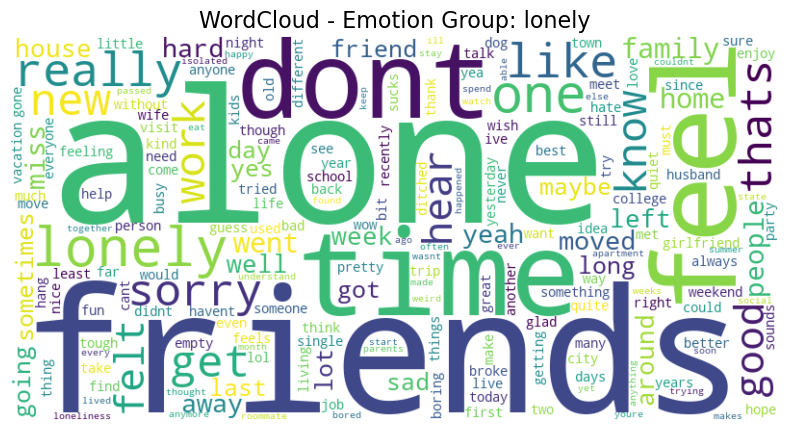

Top words for emotion group: guilt
bad: 384
feel: 332
felt: 178
really: 137
get: 114
didnt: 113
thats: 107
dont: 95
like: 93
know: 92
--------------------------------------------------


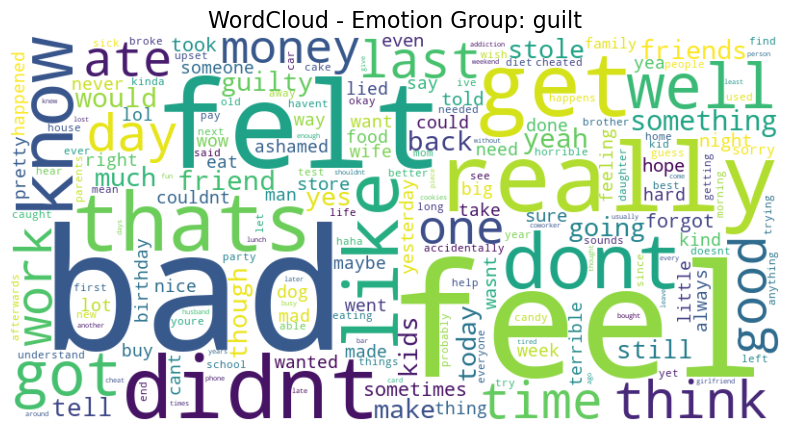

Top words for emotion group: surprise
old: 387
really: 363
like: 353
good: 353
thats: 315
got: 306
time: 302
back: 297
nice: 246
one: 227
--------------------------------------------------


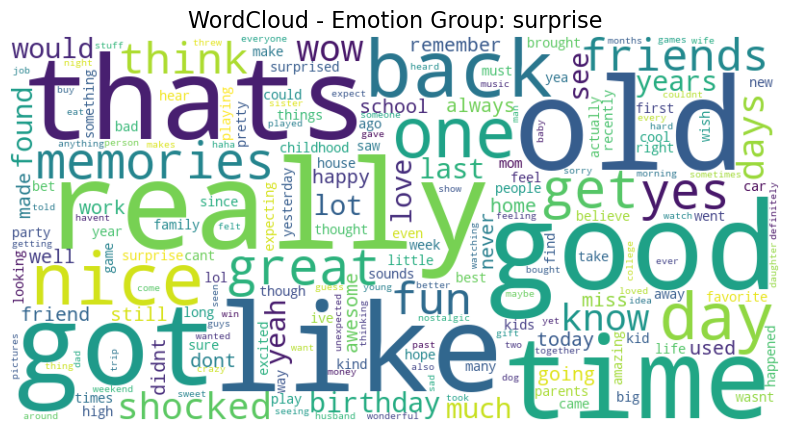

In [47]:
# Generate Word Clouds for Each Group
for group in unique_groups:
    print(f"Top words for emotion group: {group}")
    top_group_counter = generate_top_words_by_group(empathetic_df, group)
    
    for word, count in top_group_counter.most_common(10):
        print(f"{word}: {count}")
    print("-" * 50)
    
    plot_group_wordcloud(top_group_counter, group)